### Von Frey XO sequence converter


In [2]:
prj <- 'MS05'      
meta_file <- ""

sex <- "FEMALE"
species <- "rats"
data_file <- "GE29_Rats_COV.csv"
res_file <- paste('result', data_file, sep='.')

In [3]:
# Folder definitions
main_folder = ""
data_folder <- "files"
res_folder <- "res"
par_folder <- "parameters"

# Read species-specific parameters

XO_file <- paste(species, "final.previous.filaments.XO.Yaksh.csv", sep='.')
stat_file <- paste(species, "observation-statistics.csv", sep='.')

observation_table <- read.csv(file.path(par_folder, stat_file), row.names=1, stringsAsFactors=FALSE)
XO.table <- read.csv(file.path(par_folder, XO_file), row.names=1, stringsAsFactors=FALSE)

method <- 1 # method 2 - Yaksh lab; Method 1 Jenny's fast method

head(observation_table)
head(XO.table)

,STATISTIC
,<dbl>
OX,-0.500
OOX,-0.388
OOOX,-0.378
OOOOX,-0.377
OXO,0.842
OOXO,0.890


,X,O
,<dbl>,<dbl>
3.61,3.84,3.61
3.84,4.08,3.61
4.08,4.31,3.84
4.31,4.56,4.08
4.56,4.74,4.31
4.74,4.93,4.56


In [4]:
observation_table[which(rownames(observation_table) %in% c('OOOOO', 'XXXX')),]

numeric(0)

In [5]:
VonFrey = function(obs='', last=0){
    obs <- toupper(obs)
    res <- 0
    if (obs == '' | last == 0) { return ('ERR')} 
    else if (obs == 'OOOOO' & last == 5.18) { res <- 15 } 
    else if (obs == 'XXXX' & last == 3.61) { res <- 0.2 }
    else if (length(which(rownames(XO.table) == last)) == 0 | length(which(rownames(observation_table) == obs))== 0) { return ('ERR')}
    else {
    a <- substr(obs, nchar(obs)-1, nchar(obs)-1)
    prev <- XO.table[which(rownames(XO.table) == last), a]
    dif <- abs(last - prev)
    p50 <- last + dif * observation_table[which(rownames(observation_table) == obs),'STATISTIC']
    res <- (10**p50)/10000
    if (res > 15) { res <- 15 }
    if (res < 0.2) { res <- 0.20 }
    return(as.numeric(sprintf("%.2f", res)))
    }
}

In [6]:
library(DescTools)
TruncateObservation = function(obs='', met=2){
    obs <- toupper(obs)
    if (obs == '') { return ("") } 
    if (met == 2) { return (obs) }
    if (met == 1) {  # Jenny's short method
    len <- nchar(obs)  
    Xpos <- StrPos(obs, 'X') 
    if (is.na(Xpos)) { return (obs) }   
    obs1 <- substr(obs, Xpos, len)
 
    return (obs1)
    }
}

In [7]:
# READ DATA

vfdata <- read.csv(file.path(data_folder, data_file), stringsAsFactors=FALSE)

head(vfdata)

,DATE,SPECIES,SEX,GROUP,ID,ANIMAL_ID,CAGE,NOTCH,PAW,DAY,OBSERVATION,LAST
,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<int>,<chr>,<chr>,<int>,<chr>,<dbl>
1,1/13/22,,FEMALE,SCRs,A,AC225,1,L,LEFT,0,OOOOXXOXO,4.74
2,1/13/22,,FEMALE,SCRs,A,AC226,1,R,LEFT,0,OOOOO,5.18
3,1/13/22,,FEMALE,SCRs,A,AC227,1,N√ò,LEFT,0,OOOOXOXOX,5.18
4,1/14/22,,FEMALE,SCRs,A,AC340,7,L,LEFT,0,OOOOXXOXO,4.74
5,1/14/22,,FEMALE,SCRs,A,AC341,7,R,LEFT,0,OOOOXXOXO,4.74
6,1/14/22,,FEMALE,SCRs,A,AC342,7,N√ò,LEFT,0,OOOOXOXXO,4.74


In [8]:
if (sex != ""){
    vfdata <- vfdata[which(vfdata$SEX %in% c(sex)),]
    head(vfdata)
}

,DATE,SPECIES,SEX,GROUP,ID,ANIMAL_ID,CAGE,NOTCH,PAW,DAY,OBSERVATION,LAST
,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<int>,<chr>,<chr>,<int>,<chr>,<dbl>
1,1/13/22,,FEMALE,SCRs,A,AC225,1,L,LEFT,0,OOOOXXOXO,4.74
2,1/13/22,,FEMALE,SCRs,A,AC226,1,R,LEFT,0,OOOOO,5.18
3,1/13/22,,FEMALE,SCRs,A,AC227,1,N√ò,LEFT,0,OOOOXOXOX,5.18
4,1/14/22,,FEMALE,SCRs,A,AC340,7,L,LEFT,0,OOOOXXOXO,4.74
5,1/14/22,,FEMALE,SCRs,A,AC341,7,R,LEFT,0,OOOOXXOXO,4.74
6,1/14/22,,FEMALE,SCRs,A,AC342,7,N√ò,LEFT,0,OOOOXOXXO,4.74


In [9]:

for (i in 1:nrow(vfdata)){    
#    vfdata$OBS[i] <- TruncateObservation(vfdata$OBSERVATION[i], method)
    vfdata$RESULT[i] <- VonFrey(vfdata$OBSERVATION[i], vfdata$LAST[i])
}
head(vfdata)

,DATE,SPECIES,SEX,GROUP,ID,ANIMAL_ID,CAGE,NOTCH,PAW,DAY,OBSERVATION,LAST,RESULT
,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<int>,<chr>,<chr>,<int>,<chr>,<dbl>,<dbl>
1,1/13/22,,FEMALE,SCRs,A,AC225,1,L,LEFT,0,OOOOXXOXO,4.74,8.34
2,1/13/22,,FEMALE,SCRs,A,AC226,1,R,LEFT,0,OOOOO,5.18,15.00
3,1/13/22,,FEMALE,SCRs,A,AC227,1,N√ò,LEFT,0,OOOOXOXOX,5.18,11.66
4,1/14/22,,FEMALE,SCRs,A,AC340,7,L,LEFT,0,OOOOXXOXO,4.74,8.34
5,1/14/22,,FEMALE,SCRs,A,AC341,7,R,LEFT,0,OOOOXXOXO,4.74,8.34
6,1/14/22,,FEMALE,SCRs,A,AC342,7,N√ò,LEFT,0,OOOOXOXXO,4.74,9.49


In [10]:
csvfile <- paste('All', res_file, sep='.')
write.csv(vfdata, csvfile)

In [11]:
vfdata <- vfdata[which(vfdata$RESULT != 'ERR'),]
head(vfdata)

,DATE,SPECIES,SEX,GROUP,ID,ANIMAL_ID,CAGE,NOTCH,PAW,DAY,OBSERVATION,LAST,RESULT
,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<int>,<chr>,<chr>,<int>,<chr>,<dbl>,<dbl>
1,1/13/22,,FEMALE,SCRs,A,AC225,1,L,LEFT,0,OOOOXXOXO,4.74,8.34
2,1/13/22,,FEMALE,SCRs,A,AC226,1,R,LEFT,0,OOOOO,5.18,15.00
3,1/13/22,,FEMALE,SCRs,A,AC227,1,N√ò,LEFT,0,OOOOXOXOX,5.18,11.66
4,1/14/22,,FEMALE,SCRs,A,AC340,7,L,LEFT,0,OOOOXXOXO,4.74,8.34
5,1/14/22,,FEMALE,SCRs,A,AC341,7,R,LEFT,0,OOOOXXOXO,4.74,8.34
6,1/14/22,,FEMALE,SCRs,A,AC342,7,N√ò,LEFT,0,OOOOXOXXO,4.74,9.49


In [12]:

library(ggplot2)
library(ggpubr)
library(ggiraphExtra)
library(tidyverse)
library(rstatix)

── Attaching packages ─────────────────────────────────────── tidyverse 1.3.1 ──

✔ tibble  3.1.6     ✔ dplyr   1.0.7
✔ tidyr   1.1.4     ✔ stringr 1.4.0
✔ readr   2.1.1     ✔ forcats 0.5.1
✔ purrr   0.3.4     

── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()


Attaching package: ‘rstatix’


The following object is masked from ‘package:stats’:

    filter




In [13]:
#devtools::install_github("cardiomoon/ggiraphExtra")

In [14]:
`%notin%` <- Negate(`%in%`)

In [15]:
sex <- 'FEMALE'
#csvfile <- "vertical_vonFrey-11-05-20.csv"
#csvfile <- "vonFrey-11-17-20-shortterm.csv"
#csvfile <- "vonFrey-10-29-20-longterm.csv"
#csvfile <- "VF005_ALL.csv"
#csvfile <- '2021_07_VONFREY_DATA_FEMALES_D7.csv'
#csvfile <- paste('2021_07_VONFREY_DATA', sex, 'D7.result.csv', sep ='_')
#csvfile <- 'GE29_Rats_COV_Day7.result.csv'
#main_folder <- "/Users/achernov/aclab/Notebooks/vonFrey"
#csvfile <- "output2.csv"
paw_side <- c('LEFT') #'RIGHT',
#metafile <- "metafile.csv"

anal_date <- format(Sys.Date(), "%b_%d_%Y")
toPDF <- T
anal_name <- "MBP-COV peptides"
species <- "RATS" 
RELATIVE <- F

In [16]:
#x <- read.table(file="clipboard", sep='\t', header=TRUE)
#x <- as.data.frame(read.csv(input_file, stringsAsFactors=FALSE))
#m <- read.csv(metafile, row.names=1, stringsAsFactors=FALSE)

#x <- as.data.frame(t(x))

#m <- t(m)

x <- vfdata
#x <- cbind(x, m)
head(x)

,DATE,SPECIES,SEX,GROUP,ID,ANIMAL_ID,CAGE,NOTCH,PAW,DAY,OBSERVATION,LAST,RESULT
,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<int>,<chr>,<chr>,<int>,<chr>,<dbl>,<dbl>
1,1/13/22,,FEMALE,SCRs,A,AC225,1,L,LEFT,0,OOOOXXOXO,4.74,8.34
2,1/13/22,,FEMALE,SCRs,A,AC226,1,R,LEFT,0,OOOOO,5.18,15.00
3,1/13/22,,FEMALE,SCRs,A,AC227,1,N√ò,LEFT,0,OOOOXOXOX,5.18,11.66
4,1/14/22,,FEMALE,SCRs,A,AC340,7,L,LEFT,0,OOOOXXOXO,4.74,8.34
5,1/14/22,,FEMALE,SCRs,A,AC341,7,R,LEFT,0,OOOOXXOXO,4.74,8.34
6,1/14/22,,FEMALE,SCRs,A,AC342,7,N√ò,LEFT,0,OOOOXOXXO,4.74,9.49


In [17]:
#write.csv(x, paste("vertical", csvfile, sep='_'))

In [18]:
#install.packages("gapminder")
#library(gapminder)
#row.names(x) <- x$animal


lp <- x

lp <- lp[which(lp$PAW %in% c(paw_side)),]
#lp <- lp[which(lp$GROUP %in% c('A','B','C', 'D', 'E')),]
#lp <- lp[which(lp$RESULT %notin% c('ERR')),]
head(lp)
                
#lp %>% 
 #   sample_n_by(group, size = 1)
#lp %>% 



,DATE,SPECIES,SEX,GROUP,ID,ANIMAL_ID,CAGE,NOTCH,PAW,DAY,OBSERVATION,LAST,RESULT
,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<int>,<chr>,<chr>,<int>,<chr>,<dbl>,<dbl>
1,1/13/22,,FEMALE,SCRs,A,AC225,1,L,LEFT,0,OOOOXXOXO,4.74,8.34
2,1/13/22,,FEMALE,SCRs,A,AC226,1,R,LEFT,0,OOOOO,5.18,15.00
3,1/13/22,,FEMALE,SCRs,A,AC227,1,N√ò,LEFT,0,OOOOXOXOX,5.18,11.66
4,1/14/22,,FEMALE,SCRs,A,AC340,7,L,LEFT,0,OOOOXXOXO,4.74,8.34
5,1/14/22,,FEMALE,SCRs,A,AC341,7,R,LEFT,0,OOOOXXOXO,4.74,8.34
6,1/14/22,,FEMALE,SCRs,A,AC342,7,N√ò,LEFT,0,OOOOXOXXO,4.74,9.49


In [19]:
if(RELATIVE){
    lp$RELATIVE <- 100 * lp$RESULT / 15 
}

In [20]:
lp$GROUP
#lp <- lp %>%
#  reorder_levels(group, order = c("A", "B"))
levels(lp$GROUP)
lp$TIMEPOINT <- lp$DAY

if(RELATIVE) { lp$RESULT <- lp$RELATIVE }

min_res <- min(lp$RESULT)
max_res <- max(lp$RESULT)
min_res
max_res

tail(lp)

[1] "SCRs"      "SCRs"      "SCRs"      "SCRs"      "SCRs"      "SCRs"     
  [7] "MBP84-104" "MBP84-104" "MBP84-104" "MBP84-104" "MBP84-104" "MBP84-104"
 [13] "OC-WT"     "OC-WT"     "OC-WT"     "OC-WT"     "OC-WT"     "OC-WT"    
 [19] "COV2"      "COV2"      "COV2"      "COV2"      "COV2"      "COV2"     
 [25] "PBS"       "PBS"       "PBS"       "PBS"       "PBS"       "PBS"      
 [31] "SCRs"      "SCRs"      "SCRs"      "SCRs"      "SCRs"      "SCRs"     
 [37] "MBP84-104" "MBP84-104" "MBP84-104" "MBP84-104" "MBP84-104" "MBP84-104"
 [43] "OC-WT"     "OC-WT"     "OC-WT"     "OC-WT"     "OC-WT"     "OC-WT"    
 [49] "COV2"      "COV2"      "COV2"      "COV2"      "COV2"      "COV2"     
 [55] "PBS"       "PBS"       "PBS"       "PBS"       "PBS"       "PBS"      
 [61] "SCRs"      "SCRs"      "SCRs"      "SCRs"      "SCRs"      "SCRs"     
 [67] "MBP84-104" "MBP84-104" "MBP84-104" "MBP84-104" "MBP84-104" "MBP84-104"
 [73] "OC-WT"     "OC-WT"     "OC-WT"     "OC-WT"     "OC-WT"     "OC-WT"    
 [79] "COV2"      "COV2"      "COV2"      "COV2"      "COV2"      "COV2"     
 [85] "PBS"       "PBS"       "PBS"       "PBS"       "PBS"       "PBS"      
 [91] "SCRs"      "SCRs"      "SCRs"      "SCRs"      "SCRs"      "SCRs"     
 [97] "MBP84-104" "MBP84-104" "MBP84-104" "MBP84-104" "MBP84-104" "MBP84-104"
[103] "OC-WT"     "OC-WT"     "OC-WT"     "OC-WT"     "OC-WT"     "OC-WT"    
[109] "COV2"      "COV2"      "COV2"      "COV2"      "COV2"      "COV2"     
[115] "PBS"       "PBS"       "PBS"       "PBS"       "PBS"       "PBS"      
[121] "SCRs"      "SCRs"      "SCRs"      "MBP84-104" "MBP84-104" "MBP84-104"
[127] "OC-WT"     "OC-WT"     "OC-WT"     "COV2"      "COV2"      "COV2"     
[133] "PBS"       "PBS"       "PBS"       "SCRs"      "SCRs"      "SCRs"     
[139] "MBP84-104" "MBP84-104" "MBP84-104" "OC-WT"     "OC-WT"     "OC-WT"    
[145] "COV2"      "COV2"      "COV2"      "PBS"       "PBS"       "PBS"      
[151] "SCRs"      "SCRs"      "SCRs"      "MBP84-104" "MBP84-104" "MBP84-104"
[157] "OC-WT"     "OC-WT"     "OC-WT"     "COV2"      "COV2"      "COV2"     
[163] "PBS"       "PBS"       "PBS"

NULL

[1] 0.98

[1] 15

,DATE,SPECIES,SEX,GROUP,ID,ANIMAL_ID,CAGE,NOTCH,PAW,DAY,OBSERVATION,LAST,RESULT,TIMEPOINT
,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<int>,<chr>,<chr>,<int>,<chr>,<dbl>,<dbl>,<int>
319,2-Feb,RAT,FEMALE,COV2,D,AC334,5,L,LEFT,13,OOOOXXOXO,4.74,8.34,13
321,2-Feb,RAT,FEMALE,COV2,D,AC335,5,R,LEFT,13,OOOXOXOO,4.93,8.66,13
323,2-Feb,RAT,FEMALE,COV2,D,AC336,5,NØ,LEFT,13,OXOOXO,4.56,4.24,13
325,2-Feb,RAT,FEMALE,PBS,E,AC337,6,L,LEFT,13,OOOOXOXOX,5.18,11.66,13
327,2-Feb,RAT,FEMALE,PBS,E,AC338,6,R,LEFT,13,OOOXOOO,5.18,13.85,13
329,2-Feb,RAT,FEMALE,PBS,E,AC339,6,NØ,LEFT,13,OOOOXOXOO,5.18,15.00,13


## Summary statistics
Compute some summary statistics (count, mean and sd) of the variable weight organized by groups:

# Two-way ANOVA

## Summary statistics
Compute the mean and the SD (standard deviation) of the score by groups:

In [21]:
lp_stat <- lp %>%
  group_by(GROUP, TIMEPOINT) %>%
        get_summary_stats(RESULT, type = "mean_sd")

lp_stat

GROUP,TIMEPOINT,variable,n,mean,sd
<chr>,<int>,<chr>,<dbl>,<dbl>,<dbl>
COV2,0,RESULT,6,13.612,2.553
COV2,1,RESULT,6,8.195,4.634
COV2,3,RESULT,6,6.352,1.986
COV2,5,RESULT,6,7.788,3.269
COV2,7,RESULT,6,12.220,1.938
COV2,13,RESULT,3,7.080,2.465
MBP84-104,0,RESULT,6,11.805,3.461
MBP84-104,1,RESULT,6,5.083,3.112
MBP84-104,3,RESULT,6,4.933,3.190


## Visualization
Create a box plot of the score by gender levels, colored by education levels:

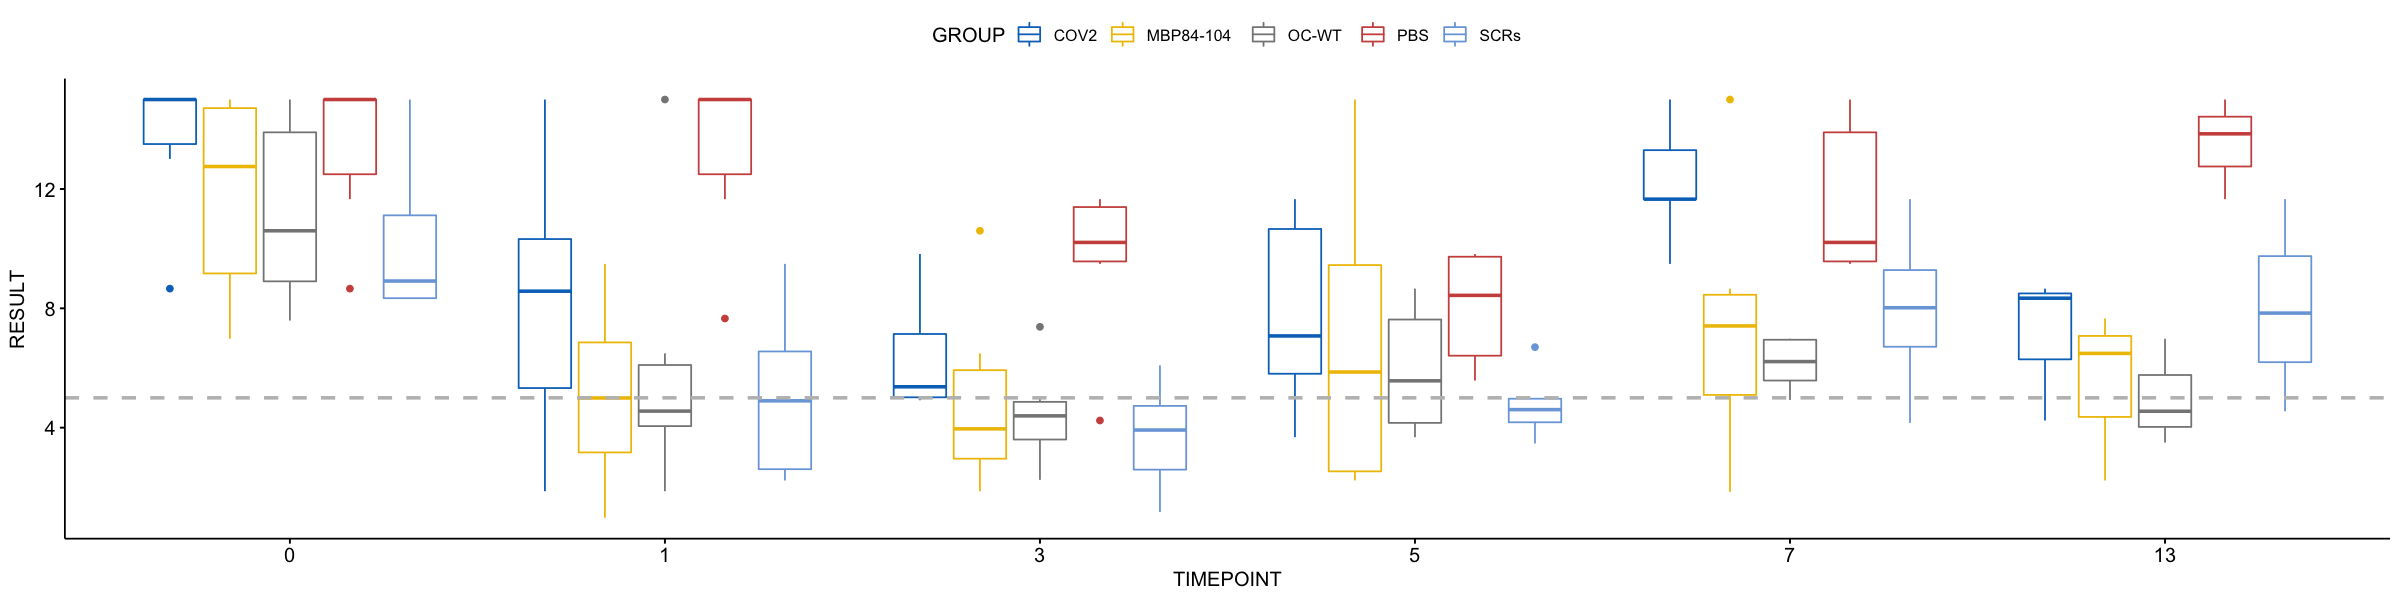

In [22]:
options(repr.plot.width=20, repr.plot.height=5) 
par(mfrow=c(1,1), mar=c(0.5,0.5,0.5,0.5))

bxp <- ggboxplot(
  lp, x = "TIMEPOINT", y = "RESULT",
  color = "GROUP", palette = "jco" #, facet.by = "paw"
  )
bxp +
    geom_hline(yintercept=5, linetype="dashed", 
                color = "gray", size=1)

In [23]:
lp %>%
  group_by( GROUP, TIMEPOINT) %>%
  identify_outliers(RESULT)

GROUP,TIMEPOINT,DATE,SPECIES,SEX,ID,ANIMAL_ID,CAGE,NOTCH,PAW,DAY,OBSERVATION,LAST,RESULT,is.outlier,is.extreme
<chr>,<int>,<chr>,<chr>,<chr>,<chr>,<chr>,<int>,<chr>,<chr>,<int>,<chr>,<dbl>,<dbl>,<lgl>,<lgl>
COV2,0,1/13/22,,FEMALE,D,AC336,5,N√ò,LEFT,0,OOOXOXOO,4.93,8.66,TRUE,TRUE
MBP84-104,3,1/24/22,,FEMALE,B,AC344,8,R,LEFT,3,OOOXOOXO,4.93,10.60,TRUE,FALSE
MBP84-104,7,,RAT,FEMALE,B,AC344,8,R,LEFT,7,OOOOO,5.18,15.00,TRUE,FALSE
OC-WT,1,1/21/22,,FEMALE,C,AC333,4,N√ò,LEFT,1,OOOOXOO,5.18,15.00,TRUE,TRUE
OC-WT,3,1/23/22,,FEMALE,C,AC333,4,N√ò,LEFT,3,OOXOOOX,5.18,7.38,TRUE,FALSE
PBS,0,1/14/22,,FEMALE,E,AC352,12,L,LEFT,0,OOOXOXOO,4.93,8.66,TRUE,FALSE
PBS,1,1/22/22,,FEMALE,E,AC352,12,L,LEFT,1,OOOOXOXXX,4.74,7.66,TRUE,FALSE
PBS,3,1/24/22,,FEMALE,E,AC354,12,N√ò,LEFT,3,OXOOXO,4.56,4.24,TRUE,FALSE
SCRs,5,2022_01_25,RAT,FEMALE,A,AC227,1,N√ò,LEFT,5,OXOOOO,4.93,6.70,TRUE,FALSE


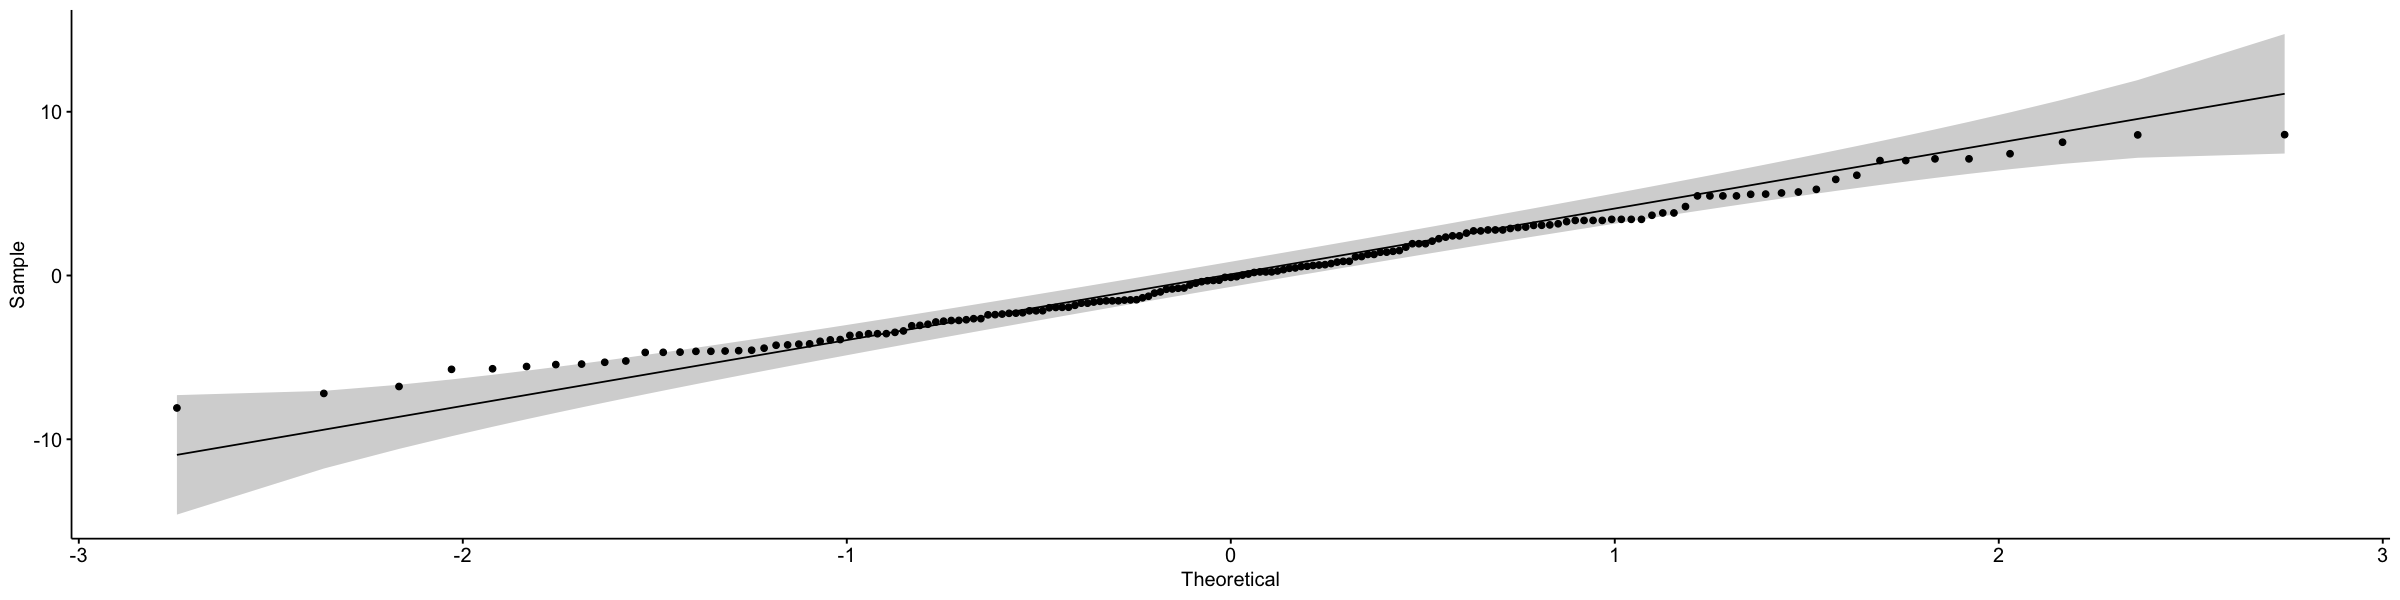

In [24]:
# Build the linear model
model  <- lm(RESULT ~ GROUP*TIMEPOINT,
             data = lp)
# Create a QQ plot of residuals
ggqqplot(residuals(model))

In [25]:
# Compute Shapiro-Wilk test of normality
shapiro_test(residuals(model))

variable,statistic,p.value
<chr>,<dbl>,<dbl>
residuals(model),0.9860929,0.0997183


In [26]:
#lp %>%
#  group_by(paw, group, day) %>%
 # shapiro_test(force)

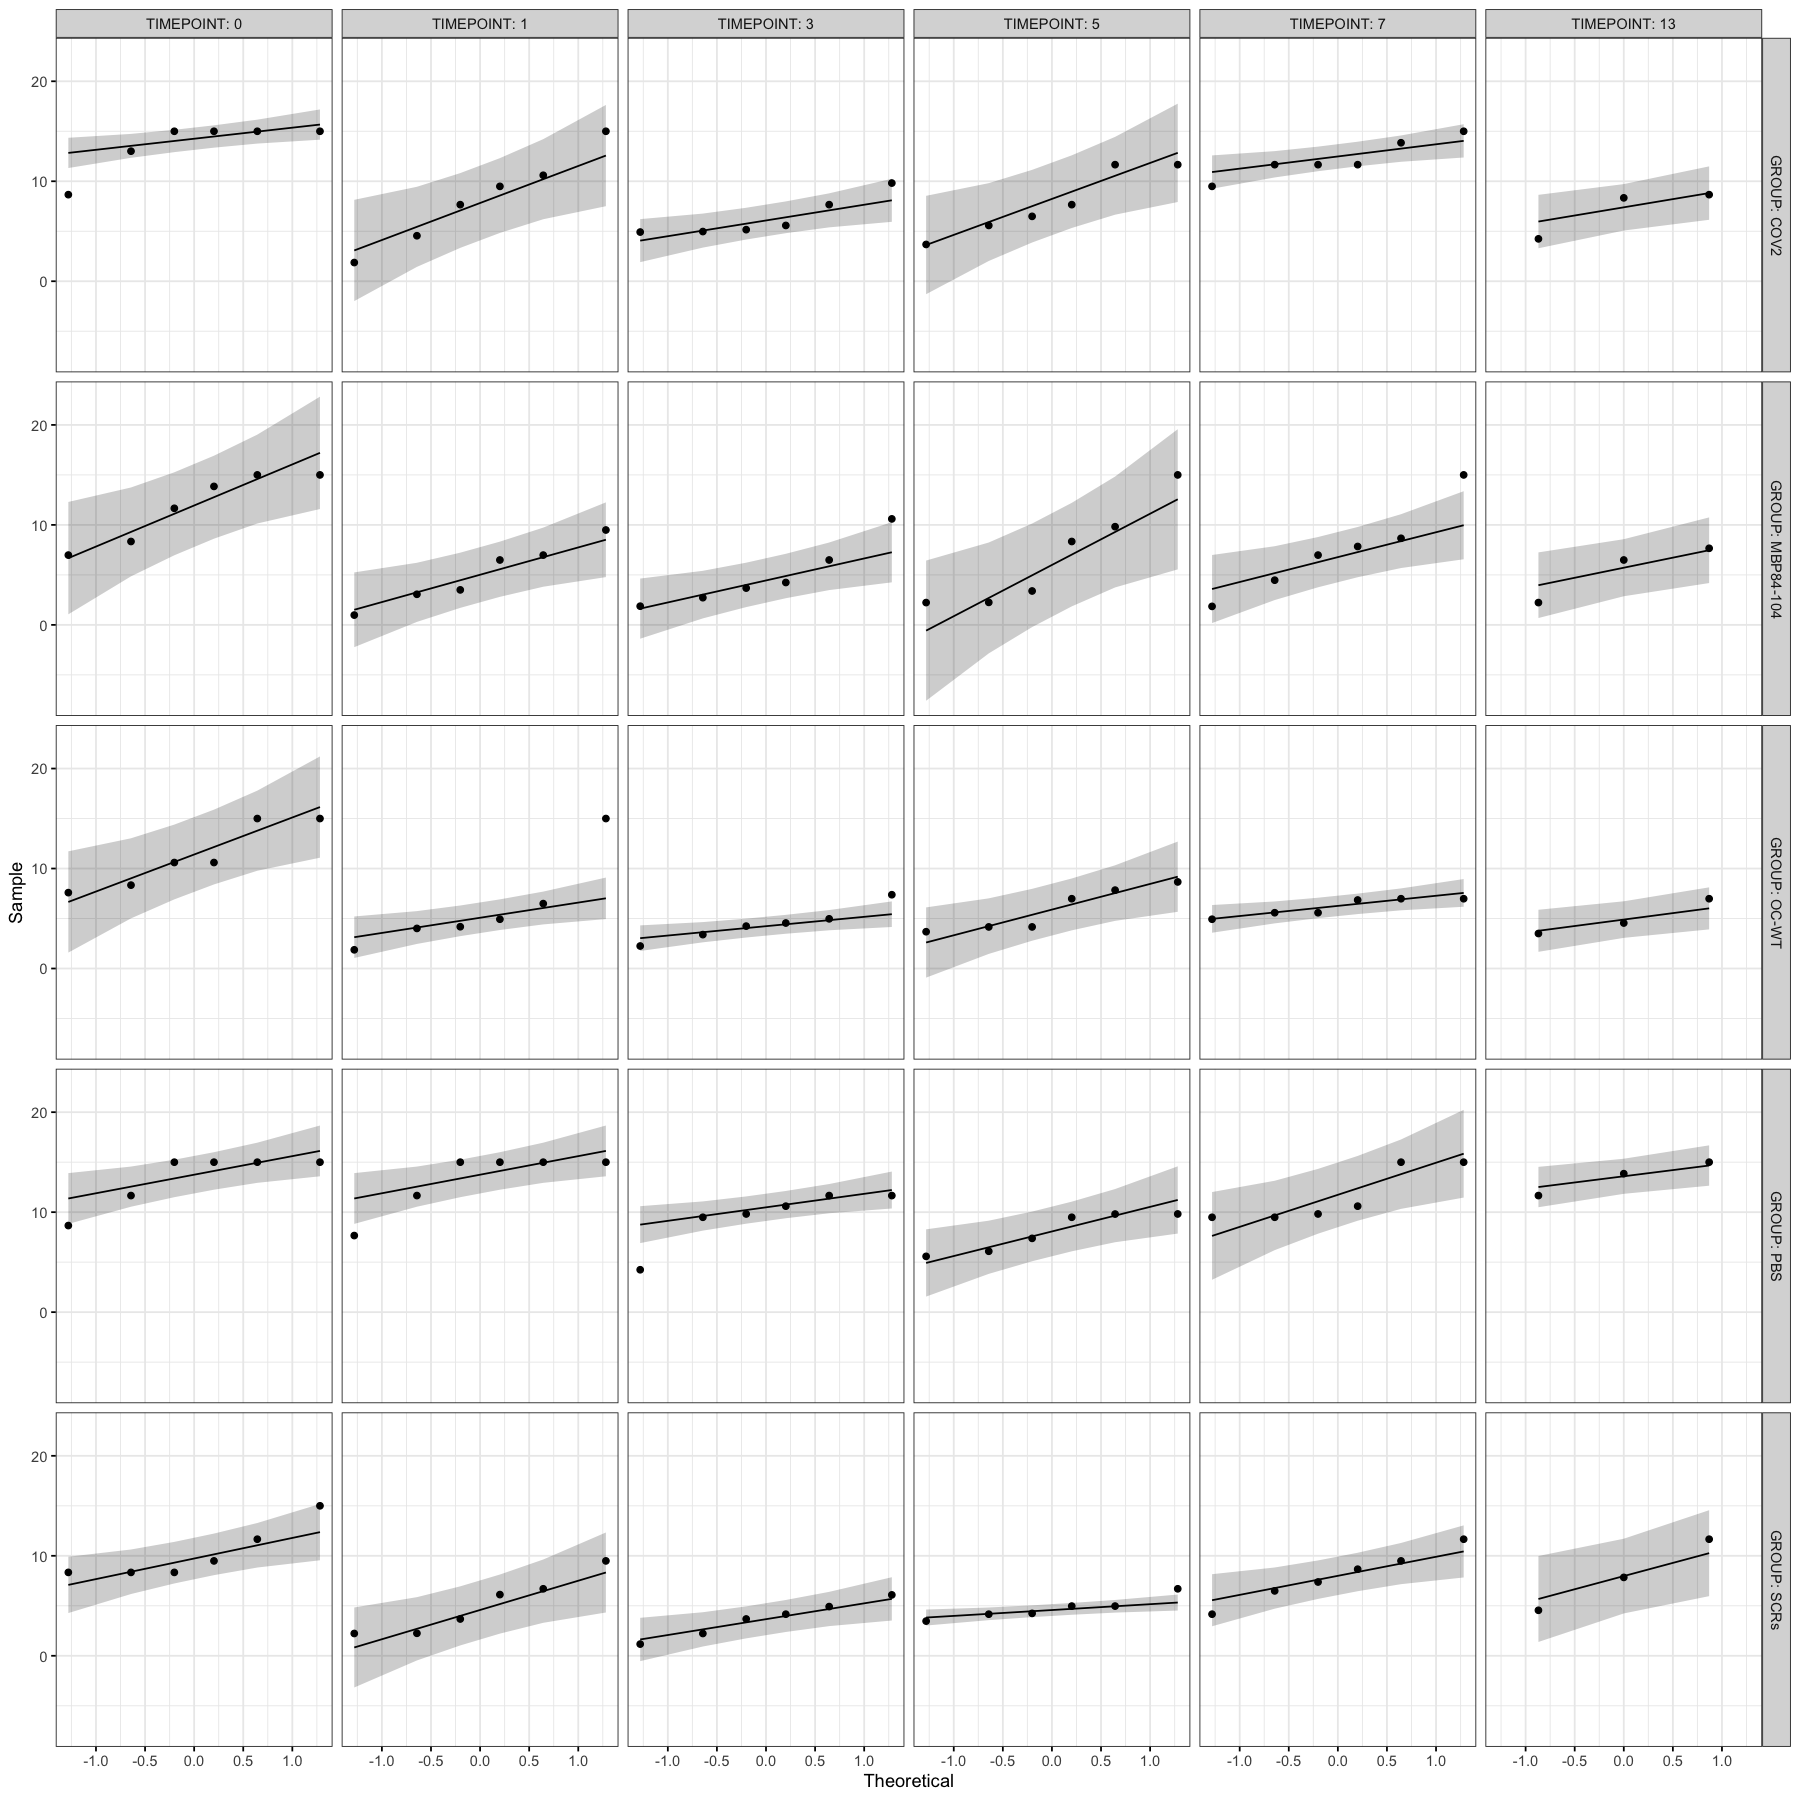

In [27]:
options(repr.plot.width=15, repr.plot.height=15) 
par(mfrow=c(1,1), mar=c(0.5,0.5,0.5,0.5))
ggqqplot(lp, "RESULT", ggtheme = theme_bw()) +
  facet_grid( GROUP ~ TIMEPOINT, labeller = "label_both")

In [28]:
#lp %>% levene_test(RESULT ~ TIMEPOINT)

In [29]:
res.aov <- lp %>% anova_test(RESULT ~ GROUP*TIMEPOINT)
res.aov

Coefficient covariances computed by hccm()



,Effect,DFn,DFd,F,p,p<.05,ges
,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<dbl>
1,GROUP,4,155,11.399,3.90e-08,*,0.227
2,TIMEPOINT,1,155,3.991,4.70e-02,*,0.025
3,GROUP:TIMEPOINT,4,155,0.606,6.59e-01,,0.015


In [30]:
# Group the data by gender and fit  anova
model <- lm(RESULT ~ GROUP * TIMEPOINT, data = lp)
lp %>%
  group_by(GROUP) %>%
      anova_test(RESULT ~ TIMEPOINT, error = model)

Coefficient covariances computed by hccm()

Coefficient covariances computed by hccm()

Coefficient covariances computed by hccm()

Coefficient covariances computed by hccm()

Coefficient covariances computed by hccm()



,GROUP,Effect,DFn,DFd,F,p,p<.05,ges
,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<dbl>
1,COV2,TIMEPOINT,1,155,1.128,0.290,,0.007000
2,MBP84-104,TIMEPOINT,1,155,1.743,0.189,,0.011000
3,OC-WT,TIMEPOINT,1,155,3.380,0.068,,0.021000
4,PBS,TIMEPOINT,1,155,0.147,0.702,,0.000948
5,SCRs,TIMEPOINT,1,155,0.019,0.891,,0.000121


In [31]:
library(emmeans)
pwc <- lp %>% 
  group_by(TIMEPOINT) %>%
  emmeans_test(RESULT ~ GROUP, model = model, p.adjust.method = "bonferroni") 
#  anova_test(RESULT ~ GROUP, error = model) #, p.adjust.method = "bonferroni")
pwc


Warning message:
“Expected 2 pieces. Additional pieces discarded in 7 rows [1, 2, 5, 6, 7, 8, 9].”


,TIMEPOINT,term,.y.,group1,group2,df,statistic,p,p.adj,p.adj.signif
,<dbl>,<chr>,<chr>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>
1,4.090909,GROUP,RESULT,COV2,MBP84,155,2.6114573,9.901538e-03,9.901538e-02,ns
2,4.090909,GROUP,RESULT,COV2,OC,155,3.1310391,2.082446e-03,2.082446e-02,*
3,4.090909,GROUP,RESULT,COV2,PBS,155,-2.1999241,2.929254e-02,2.929254e-01,ns
4,4.090909,GROUP,RESULT,COV2,SCRs,155,3.2499264,1.415883e-03,1.415883e-02,*
5,4.090909,GROUP,RESULT,MBP84,104,155,0.5195818,6.040963e-01,1.000000e+00,ns
6,4.090909,GROUP,RESULT,MBP84,104,155,-4.8113814,3.525557e-06,3.525557e-05,****
7,4.090909,GROUP,RESULT,MBP84,104,155,0.6384691,5.241106e-01,1.000000e+00,ns
8,4.090909,GROUP,RESULT,OC,WT,155,-5.3309632,3.394371e-07,3.394371e-06,****
9,4.090909,GROUP,RESULT,OC,WT,155,0.1188874,9.055185e-01,1.000000e+00,ns


In [32]:
pwc <- pwc %>% add_xy_position(x = "TIMEPOINT")
pwc.filtered <- pwc %>% filter((group1 == "OC" & group2 == "PBS") )#| ((group1 == "RA" & group2 == "RB")))

pwc.filtered$p.format <- p_format(pwc.filtered$p, accuracy = 0.0001, leading.zero = TRUE)
pwc$p.format <- p_format(pwc$p.adj, accuracy = 0.0001, leading.zero = FALSE)

In [33]:
toPDF <- F


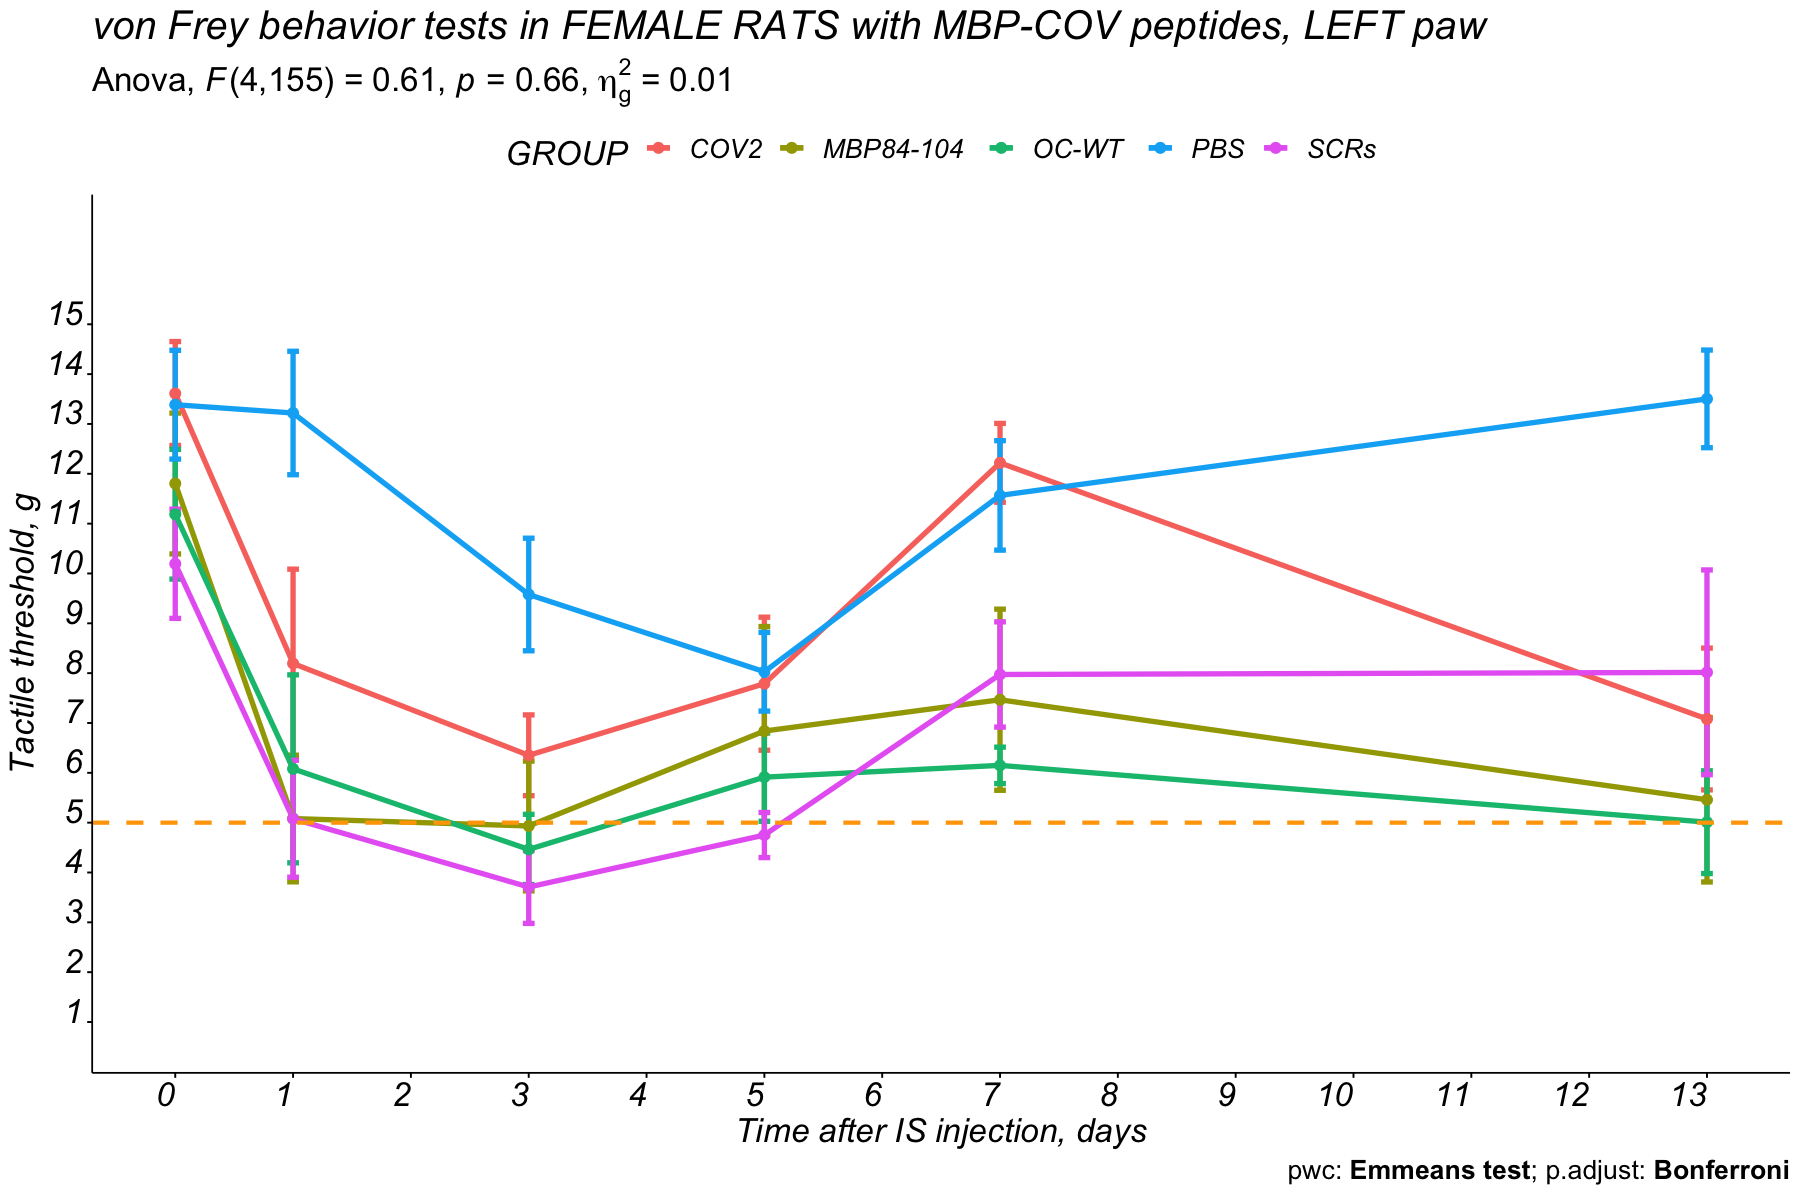

In [38]:
# Visualization: box plots with p-values
options(repr.plot.width=15, repr.plot.height=10) 
par(mfrow=c(1,1), mar=c(0.5,0.5,0.5,0.5))

y_min <- round(min(lp$RESULT))
x_max <- round(max(lp$TIMEPOINT)) + 1

p <- ggline(
            lp, #lp, 
            x = "TIMEPOINT",
            y = "RESULT", 
            size = 1.5,            
            color = "GROUP",
            linetype = "solid",
            ylim = c(min_res-1, max_res+1),
            add = c("mean_se" ), #"boxplot", "violin","jitter", 
            add.params = list(width = 0.1, shape = 15)#,
            #palette = c("magenta", "purple") #, "green", "navy")
            )+   #  geom_boxplot(width = 2, alpha=0.2) +
    stat_pvalue_manual(
            pwc.filtered, 
            label = "p = {p.format}", #paste("p = {p.format}", "{p.signif}", sep = ', '),
            size = 6,
            position = position_dodge(0.8)
            ) +

    labs(
            subtitle = get_test_label(res.aov, detailed = TRUE),
            caption = get_pwc_label(pwc)
        ) +

    scale_fill_brewer(palette="Set1")+
    xlab("Time after IS injection, days") +
    ylab("Tactile threshold, g") +
    ggtitle(sprintf("von Frey behavior tests in %s %s with %s, %s paw", sex, species, anal_name, paw_side)) +
#    scale_shape_manual(values=c(18, 16, 17, 15)) +
    theme(text = element_text(size=20, color = "black", angle = 0, hjust = .5, vjust = 0, face = "italic"),
    axis.text.x = element_text(hjust=1)) +
    geom_hline(yintercept=5, linetype="dashed", 
                color = "orange", size=1.2) +
    #geom_hline(yintercept=c(0, 1,2,3,4), linetype="dashed", 
    #            color = "gray", size=0.3) +
    scale_y_continuous( breaks=y_min:15*1, expand = expansion(mult = c(0, 0.1))  ) +  #, trans = 'log2'
    scale_x_continuous(breaks=0:x_max*1) +     


if (toPDF){
            pdf(sprintf("vonFrey %s %s %s.pdf", anal_name, anal_date, paw_side), width = 20, height = 20)
            plot(p)
            dev.off()
}
plot(p)

In [35]:
lp %>% head

,DATE,SPECIES,SEX,GROUP,ID,ANIMAL_ID,CAGE,NOTCH,PAW,DAY,OBSERVATION,LAST,RESULT,TIMEPOINT
,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<int>,<chr>,<chr>,<int>,<chr>,<dbl>,<dbl>,<int>
1,1/13/22,,FEMALE,SCRs,A,AC225,1,L,LEFT,0,OOOOXXOXO,4.74,8.34,0
2,1/13/22,,FEMALE,SCRs,A,AC226,1,R,LEFT,0,OOOOO,5.18,15.00,0
3,1/13/22,,FEMALE,SCRs,A,AC227,1,N√ò,LEFT,0,OOOOXOXOX,5.18,11.66,0
4,1/14/22,,FEMALE,SCRs,A,AC340,7,L,LEFT,0,OOOOXXOXO,4.74,8.34,0
5,1/14/22,,FEMALE,SCRs,A,AC341,7,R,LEFT,0,OOOOXXOXO,4.74,8.34,0
6,1/14/22,,FEMALE,SCRs,A,AC342,7,N√ò,LEFT,0,OOOOXOXXO,4.74,9.49,0


In [36]:
lp_stat

GROUP,TIMEPOINT,variable,n,mean,sd
<chr>,<int>,<chr>,<dbl>,<dbl>,<dbl>
COV2,0,RESULT,6,13.612,2.553
COV2,1,RESULT,6,8.195,4.634
COV2,3,RESULT,6,6.352,1.986
COV2,5,RESULT,6,7.788,3.269
COV2,7,RESULT,6,12.220,1.938
COV2,13,RESULT,3,7.080,2.465
MBP84-104,0,RESULT,6,11.805,3.461
MBP84-104,1,RESULT,6,5.083,3.112
MBP84-104,3,RESULT,6,4.933,3.190


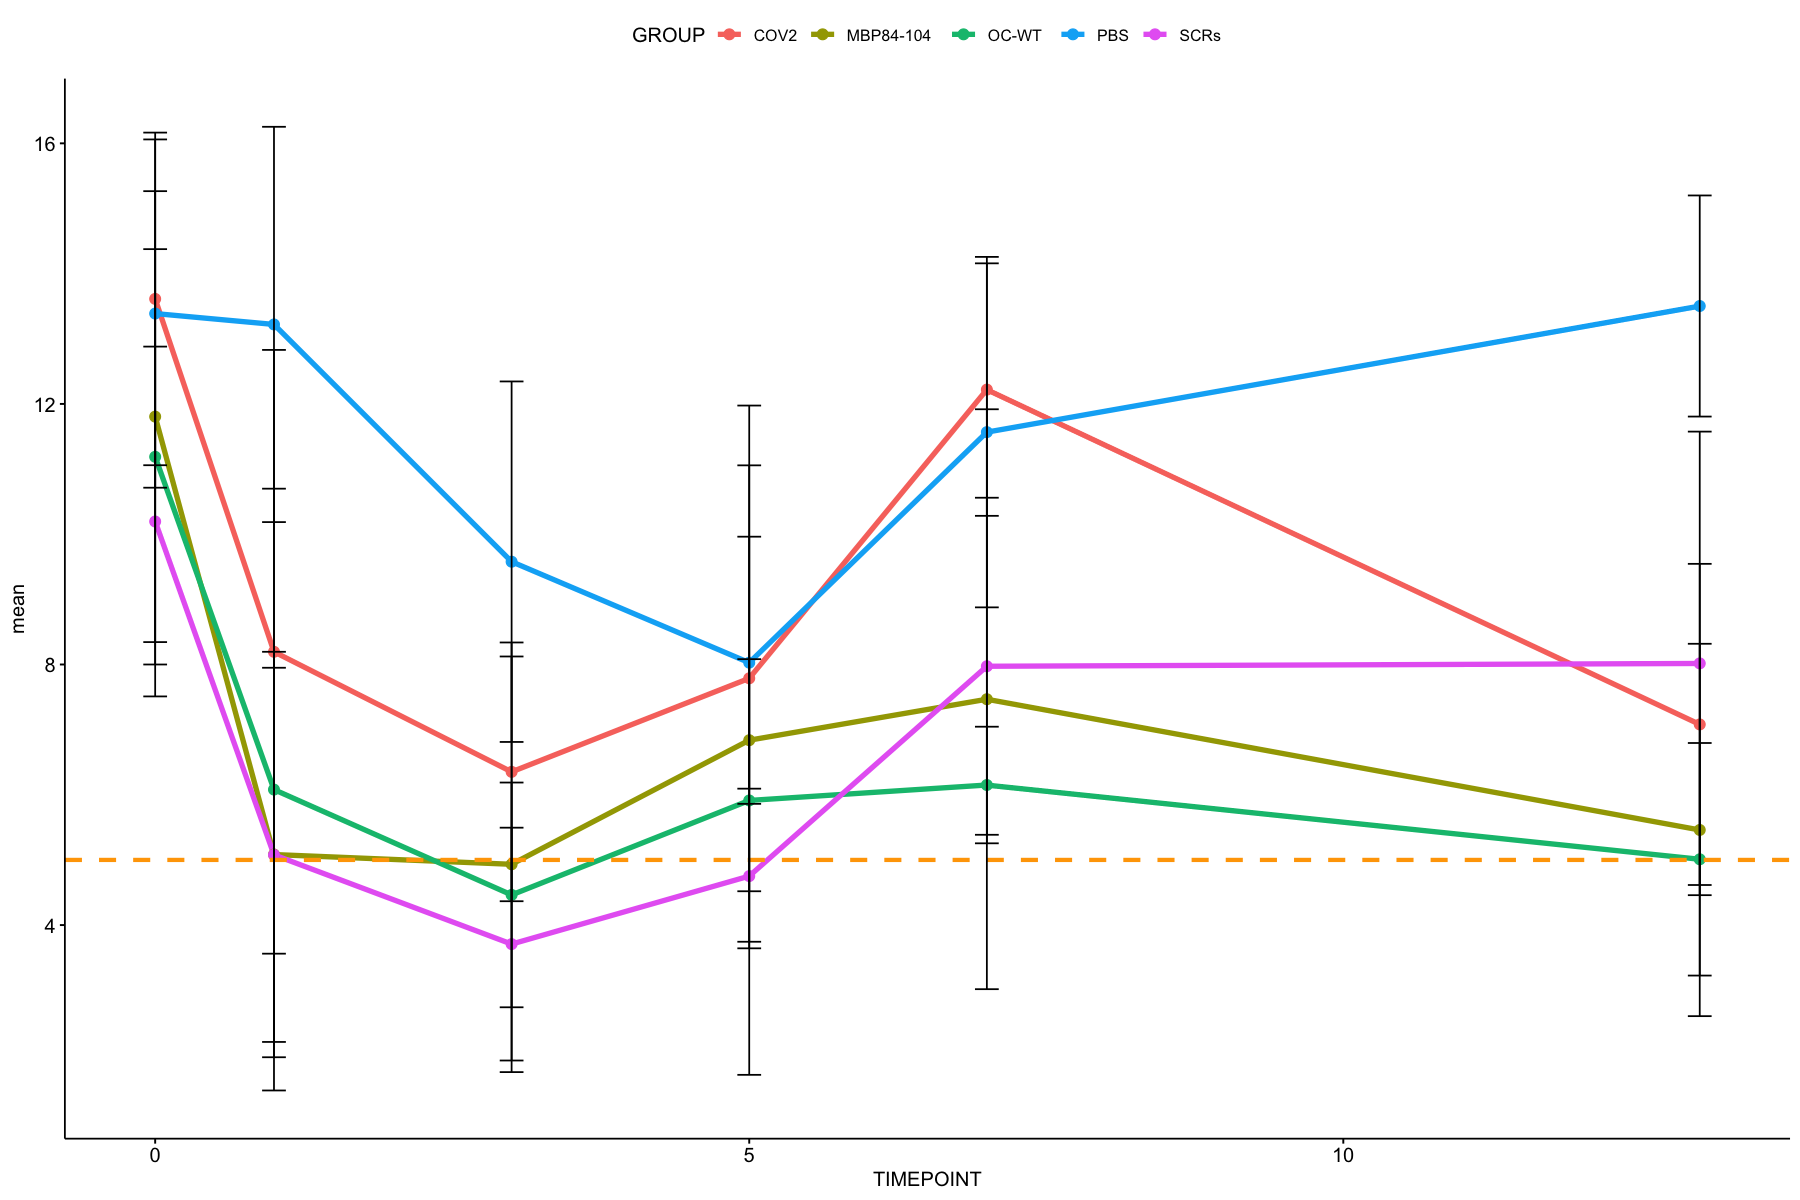

In [37]:
# Visualization: box plots with p-values
options(repr.plot.width=15, repr.plot.height=10) 
par(mfrow=c(1,1), mar=c(0.5,0.5,0.5,0.5))

y_min <- round(min(lp$RESULT))
x_max <- round(max(lp$TIMEPOINT)) + 1

p <- ggline(
            lp_stat, #lp, 
            x = "TIMEPOINT",
            y = "mean", 
            size = 1.5,            
            color = "GROUP",
            linetype = "solid",
          #  ylim = c(min_res-1, max_res+1),
    #        add = c("mean_se" ), #"boxplot", "violin","jitter", 
   #         add.params = list(width = 0.1, shape = 15)#,
            #palette = c("magenta", "purple") #, "green", "navy")
            )+
    geom_hline(yintercept=5, linetype="dashed", 
                color = "orange", size=1.2)+
geom_errorbar(aes(ymin=mean-sd, ymax=mean+sd), width=.2)
plot(p)

In [41]:
sessionInfo()

R version 4.1.2 (2021-11-01)
Platform: x86_64-apple-darwin13.4.0 (64-bit)
Running under: macOS Big Sur 10.16

Matrix products: default
BLAS/LAPACK: /Users/achernov/opt/anaconda3/envs/PyR4/lib/libopenblasp-r0.3.18.dylib

locale:
[1] C/UTF-8/C/C/C/C

attached base packages:
[1] stats     graphics  grDevices utils     datasets  methods   base     

other attached packages:
 [1] emmeans_1.7.2      rstatix_0.7.0      forcats_0.5.1      stringr_1.4.0     
 [5] dplyr_1.0.7        purrr_0.3.4        readr_2.1.1        tidyr_1.1.4       
 [9] tibble_3.1.6       tidyverse_1.3.1    ggiraphExtra_0.3.0 ggpubr_0.4.0      
[13] ggplot2_3.3.5      DescTools_0.99.44 

loaded via a namespace (and not attached):
 [1] nlme_3.1-155       fs_1.5.2           lubridate_1.8.0    insight_0.15.0    
 [5] RColorBrewer_1.1-2 httr_1.4.2         ggsci_2.9          repr_1.1.4        
 [9] tools_4.1.2        backports_1.4.1    utf8_1.2.2         R6_2.5.1          
[13] sjlabelled_1.1.8   DBI_1.1.2          mgcv_1.8-38